# The Fluties 

This is a statistical analysis of at this point 8 years of a fantasy football league. 

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv

load_dotenv()
current_year = int(os.getenv('current_year'))
full_teams = pd.read_csv("processed_teams.csv")

## Using Scaled Data

The data needs scaled to account for difference between years. There may have been different amounts of teams, different scoring rules, or a myriad of other things. 

StandardScaler from Scikit-Learn helps by turning a numeric column into z-scores. These will be calculated per year. This allows for comparing across many years to be standardized. 

### The Worst Teams

Notice the third worst with 8 wins.

In [3]:
full_teams[["abbrev", "year", "scaled_pointsFor", "record.overall.pointsFor", "record.overall.wins"]].sort_values("scaled_pointsFor").head(10)

,abbrev,year,scaled_pointsFor,record.overall.pointsFor,record.overall.wins
110,STP,2012,-2.930836,953.0,2
34,JJC,2016,-2.671726,1064.8,4
33,JJC,2015,-2.524540,1293.8,8
62,TSHU,2014,-1.674177,1305.6,3
105,SCD,2017,-1.627489,1117.2,4
58,TWS,2020,-1.624200,1371.7,2
39,TMB,2021,-1.499869,1588.3,4
52,WRIG,2014,-1.468017,1328.3,4
31,KMU,2013,-1.430624,1249.4,6
101,SCD,2013,-1.413503,1251.9,3


### The Best Teams

In [4]:
full_teams[["abbrev", "year", "scaled_pointsFor", "record.overall.pointsFor", "record.overall.wins"]].sort_values("scaled_pointsFor", ascending=False).head(10)

,abbrev,year,scaled_pointsFor,record.overall.pointsFor,record.overall.wins
117,JFSF,2019,2.158259,1916.6,7
6,#1,2018,2.084734,2263.1,10
91,JJJ,2013,2.029172,1754.6,9
42,DURA,2014,1.875039,1696.4,8
88,faq,2020,1.743053,2064.4,10
85,win,2017,1.646091,1615.8,9
119,NPZ,2021,1.507934,2116.6,11
68,BBc,2020,1.463542,2006.9,9
90,WRIG,2012,1.343201,1518.0,5
63,TSHU,2015,1.302316,1555.4,8


## Teams with the Worst Points Against
These teams could not catch a break. They were always playing the opposite team during that team's best week.

In [5]:
full_teams[["abbrev", "year", "scaled_pointsAgainst", "record.overall.pointsAgainst", "record.overall.wins"]].sort_values("scaled_pointsAgainst", ascending=False).head(10)

,abbrev,year,scaled_pointsAgainst,record.overall.pointsAgainst,record.overall.wins
118,MAGA,2020,2.184149,1912.3,2
90,WRIG,2012,2.178263,1538.0,5
99,JJJ,2021,2.063998,2047.2,3
94,JJJ,2016,1.865552,1607.0,3
106,SCD,2018,1.677092,2054.1,2
21,WRIG,2013,1.596828,1546.9,5
23,WRIG,2015,1.527711,1637.4,5
105,SCD,2017,1.515065,1455.4,4
2,MK,2014,1.251402,1590.7,5
95,JJJ,2017,1.174532,1435.1,4


## Distribution

Here is everything laid out in a box plot. The outliers are preserved so they can be easily visualized. These are not included in calculations.

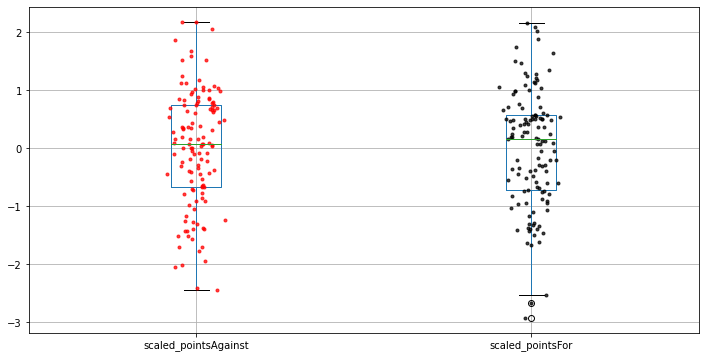

In [6]:
ax = full_teams.boxplot(column=["scaled_pointsAgainst", "scaled_pointsFor"], figsize=(12,6))
for index, t in full_teams.iterrows():
    y = t["scaled_pointsFor"]
    x = np.random.normal(2, 0.04)
    ax.plot(x, y, 'k.', alpha=0.75)
    y_for = t["scaled_pointsAgainst"]
    x_for = np.random.normal(1, 0.04)
    ax.plot(x_for, y_for, 'r.', alpha=0.75)


## Linear Regression
The models show that the correlation is weak. The charts do show that it exists. Wins being so discrete allows more outliers from the fitted line. A win or loss by 0.1 point is still a discrete win or loss.

In [7]:
for_mod = sm.OLS(full_teams['record.overall.wins'], sm.add_constant(full_teams['scaled_pointsFor']))
for_res = for_mod.fit()

against_mod = sm.OLS(full_teams['record.overall.wins'], sm.add_constant(full_teams['scaled_pointsAgainst']))
against_res = against_mod.fit()

moves_mod = sm.OLS(full_teams['record.overall.wins'], sm.add_constant(full_teams['scaled_moves']))
moves_res = against_mod.fit()

In [8]:
for_res.rsquared

0.40695706205043736

In [9]:
against_res.rsquared

0.3327144677401034

In [10]:
moves_res.rsquared

0.3327144677401034

Text(0.5, 0, 'Moves')

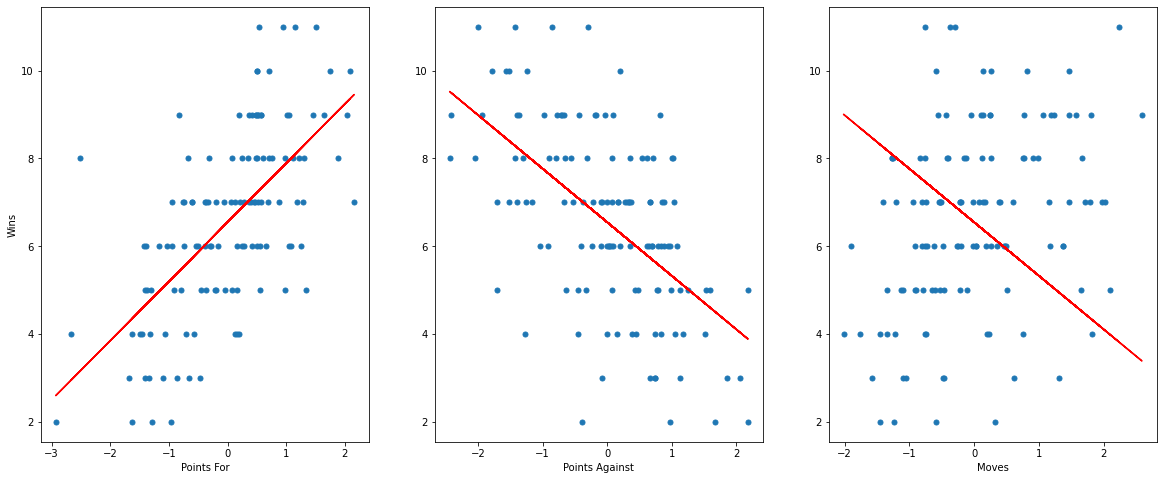

In [11]:
def regress_plot(slope, intercept, x, y, plt):
    plt.plot(x, y, 'o', markersize=5)

    plt.plot(x, slope*x + intercept, 'r')
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
regress_plot(for_res.params[1], for_res.params[0], full_teams['scaled_pointsFor'], full_teams['record.overall.wins'], ax[0])
regress_plot(against_res.params[1], against_res.params[0], full_teams['scaled_pointsAgainst'], full_teams['record.overall.wins'], ax[1])
regress_plot(moves_res.params[1], moves_res.params[0], full_teams['scaled_moves'], full_teams['record.overall.wins'], ax[2])
ax[0].set_xlabel('Points For')
ax[0].set_ylabel('Wins')
ax[1].set_xlabel('Points Against')
ax[2].set_xlabel('Moves')

## Multiple Variable Regression

Points for and points against will get a fairly strong correaltion to wins. 

In [13]:
both_mod = sm.OLS(full_teams['record.overall.wins'], sm.add_constant(full_teams[['scaled_pointsFor', 'scaled_pointsAgainst']]))
both_res = both_mod.fit()

both_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     record.overall.wins   R-squared:                       0.657
Model:                             OLS   Adj. R-squared:                  0.651
Method:                  Least Squares   F-statistic:                     115.8
Date:                 Mon, 10 Jan 2022   Prob (F-statistic):           8.02e-29
Time:                         22:43:06   Log-Likelihood:                -202.31
No. Observations:                  124   AIC:                             410.6
Df Residuals:                      121   BIC:                             419.1
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.5484      0.112     58.235      0.000       6.326       6.771
scaled_pointsFor         1.2116      0.113     10.688      0.000       0.987       1.436
scaled_pointsAgainst    -1.0638      0.113     -9.384      0.000      -1.288      -0.839
==============================================================================
Omnibus:                        1.366   Durbin-Watson:                   2.334
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                1.247
Skew:                           0.098   Prob(JB):                        0.536
Kurtosis:                       2.549   Cond. No.                         1.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Current Year Corrections

Corrections based on the entire history of the league.

In [14]:
full_teams["residuals"] = both_res.resid
full_teams["pred_wins"] = both_res.fittedvalues

current = full_teams.loc[full_teams["year"] == current_year]
current[["abbrev", "year", "record.overall.wins", "pred_wins", "residuals", "playoffSeed"]].sort_values("pred_wins", ascending=False).head(12)

,abbrev,year,record.overall.wins,pred_wins,residuals,playoffSeed
79,2021,2021,10,9.047102,0.952898,2
9,Caw,2021,8,8.982354,-0.982354,5
119,NPZ,2021,11,8.684842,2.315158,1
59,BD,2021,9,8.540700,0.459300,3
69,Rock,2021,7,6.411601,0.588399,6
109,BMT,2021,8,6.383273,1.616727,4
89,faq,2021,7,5.990661,1.009339,7
19,TOTY,2021,7,5.959197,1.040803,8
29,Sith,2021,5,5.526737,-0.526737,9
49,Mill,2021,5,5.442925,-0.442925,10


### All Time Underperformers

In [15]:
full_teams[["abbrev", "year", "record.overall.wins", "pred_wins", "residuals", "playoffSeed"]].sort_values("residuals").head(10)

,abbrev,year,record.overall.wins,pred_wins,residuals,playoffSeed
103,SCD,2015,4,6.753631,-2.753631,12
117,JFSF,2019,7,9.398834,-2.398834,5
96,JJJ,2018,4,6.286821,-2.286821,10
81,DURA,2013,6,8.160771,-2.160771,8
70,HOLD,2012,4,6.157113,-2.157113,15
35,JJC,2017,3,5.005895,-2.005895,12
73,SSGW,2015,4,5.993139,-1.993139,11
24,Seth,2016,3,4.956984,-1.956984,11
77,#50%,2019,5,6.898538,-1.898538,11
45,Mill,2017,7,8.864583,-1.864583,5


### All Time Overperformers

In [16]:
full_teams[["abbrev", "year", "record.overall.wins", "pred_wins", "residuals", "playoffSeed"]].sort_values("residuals", ascending=False).head(10)

,abbrev,year,record.overall.wins,pred_wins,residuals,playoffSeed
33,JJC,2015,8,4.328422,3.671578,5
8,#1,2020,11,8.598539,2.401461,1
119,NPZ,2021,11,8.684842,2.315158,1
97,JJJ,2019,7,4.709573,2.290427,2
76,#WIN,2018,7,4.945038,2.054962,7
40,WRIG,2012,6,3.979373,2.020627,10
84,win,2016,9,7.024768,1.975232,5
31,KMU,2013,6,4.082589,1.917411,6
57,TWS,2019,7,5.201826,1.798174,3
64,JIAT,2016,8,6.318043,1.681957,3


eval_env: 1


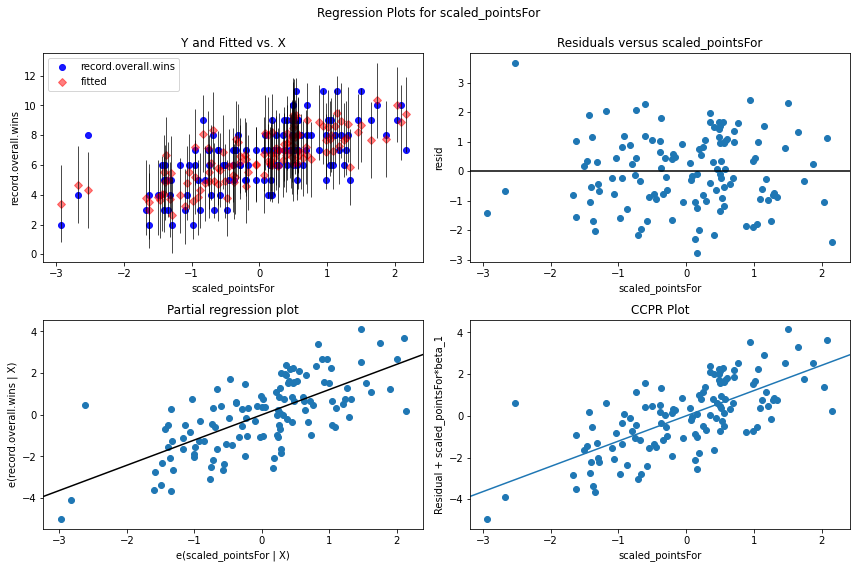

In [17]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(both_res, "scaled_pointsFor", fig=fig)